In [68]:
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import collections
import pandas as pd

In [69]:
def extract_gold(file_path: str):

    with open(file_path, encoding="utf8") as f:
        datas = json.load(f)

    group_gold = {}
    datasets = datas["datasets"]

    for d in datasets:
        group_gold[d["dataset_name"]] = d["metadata"]["groups"]

    return group_gold

# Analyse et visualisation sur la répartition des groupes

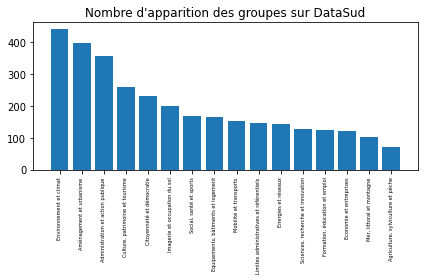

In [70]:
file_path = "../../data/datasud.json"
group_gold = extract_gold(file_path)
c = collections.Counter()
for g_value in group_gold.values():
    c.update(g_value)
c = c.most_common()

_, ax = plt.subplots()
ax.tick_params(axis="x", labelsize=5)
plt.title(f"Nombre d\'apparition des groupes sur DataSud")
plt.xticks(rotation="vertical")
plt.bar([c[0] for c in c], [c[1] for c in c])
plt.tight_layout()
plt.show()

Counter({1: 861, 2: 600, 0: 258, 3: 202, 4: 69, 7: 17, 5: 14, 6: 3, 13: 2, 14: 1, 15: 1, 8: 1})


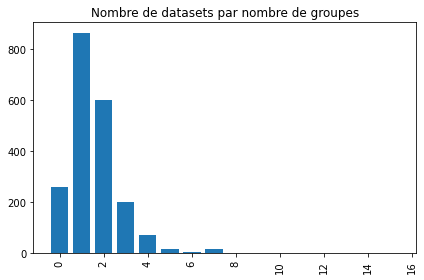

In [71]:
len_c = collections.Counter(list(map(len,group_gold.values())))

print(len_c)
_, ax = plt.subplots()
plt.title(f"Nombre de datasets par nombre de groupes")
plt.xticks(rotation="vertical")
plt.bar(len_c.keys(), len_c.values())
plt.tight_layout()
plt.show()

# Extraction des données gold et alignement avec les données prédites

In [72]:
def get_groups_len(file_path,l) :

    with open(f"{file_path}", "rb") as input_file:
        clusters = pickle.load(input_file)

    gold = []
    pred = []

    le =  preprocessing.LabelEncoder()
    all_group = list({x for l in group_gold.values() for x in l})
    le.fit(all_group)

    for dataset,groups in group_gold.items() :
        if len(groups) == l :
            gold.append(le.transform(groups)[0])
            pred.append(clusters[dataset])

    return gold,pred

# Calcul des différents scores

In [73]:
SHOW = False

In [74]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure, pair_confusion_matrix, contingency_matrix
from sklearn.metrics import rand_score, fowlkes_mallows_score

def evaluate_clusters(gold,pred,show=SHOW,repr = "",model =""):
    rand = rand_score(gold,pred)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(gold,pred)
    fowlkes_mallows = fowlkes_mallows_score(gold,pred)
    pair_confusion = pair_confusion_matrix(gold,pred)
    contingency = contingency_matrix(gold, pred)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    if show :
        print(f"For {len(gold)} datas :")
        print(f"Rand index = {rand}")
        #A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
        print(f"Homogeneity = {homogeneity}") #
        #A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
        print(f"Completeness = {completeness}")
        #The V-measure is the harmonic mean between homogeneity and completeness:
        print(f"V measure = {v_measure}")
        #The Fowlkes-Mallows score FMI is defined as the geometric mean of the pairwise precision and recall
        print(f"Fowlkes-Mallows = {fowlkes_mallows}")
        #To compute purity , each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured by counting the number of correctly assigned documents and dividing by N.
        print(f"Purity = {purity}")
        sns.heatmap(pair_confusion, annot=True).set_title("Pair Confusion Matrix")

    return {"representation" : repr,"model" : model,"homogeneity" : homogeneity,"completeness" : completeness,"v_measure" : v_measure,"fowlkes_mallows" : fowlkes_mallows,"purity":purity}

In [75]:
all_results = []

### En utilisant les contextual embedding

In [76]:
print("SBert Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_ac.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="Agglomerative Clustering (10 clusters)"))

SBert Agglomerative Clustering (10 clusters)


In [77]:
print("Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_ac_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="Agglomerative Clustering (15 clusters)"))

Agglomerative Clustering (15 clusters)


In [78]:
print("K-Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_km.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="K_Means (10 clusters)"))

K-Means (10 clusters)


In [79]:
print("K-Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_km_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="K_Means (15 clusters)"))

K-Means (15 clusters)


In [80]:
print("Spectral Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_sc.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="Spectral Clustering (10 clusters)"))

Spectral Clustering (10 clusters)


In [81]:
print("Spectral Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/sbert_clusters_datasud_sc_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="SBert", model="Spectral Clustering (15 clusters)"))

Spectral Clustering (15 clusters)


### En utilisant TF-IDF

In [82]:
print("Using TF-IDF Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_ac_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="Agglomerative Clustering (10 clusters)"))

Using TF-IDF Agglomerative Clustering (10 clusters)


In [83]:
print("Using TF-IDF Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_ac_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="Agglomerative Clustering (15 clusters)"))

Using TF-IDF Agglomerative Clustering (15 clusters)


In [84]:
print("Using TF-IDF K_Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_km.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="K_Means (10 clusters)"))

Using TF-IDF K_Means (10 clusters)


In [85]:
print("Using TF-IDF K_Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_km_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="K_Means (15 clusters)"))

Using TF-IDF K_Means (15 clusters)


In [86]:
print("Using TF-IDF Spectral Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_sc_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="Spectral Clustering (10 clusters)"))

Using TF-IDF Spectral Clustering (10 clusters)


In [87]:
print("Using TF-IDF Spectral Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/tfidf_clusters_datasud_sc_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="TF_IDF", model="Spectral Clustering (15 clusters)"))

Using TF-IDF Spectral Clustering (15 clusters)


### En utilisant LSA

In [88]:
print("Using LSA Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_ac_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="Agglomerative Clustering (10 clusters)"))

Using LSA Agglomerative Clustering (10 clusters)


In [89]:
print("Using LSA Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_ac_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="Agglomerative Clustering (15 clusters)"))

Using LSA Agglomerative Clustering (15 clusters)


In [90]:
print("Using LSA K_Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_km_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="K_Means (10 clusters)"))

Using LSA K_Means (10 clusters)


In [91]:
print("Using LSA K_Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_km_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="K_Means (15 clusters)"))

Using LSA K_Means (15 clusters)


In [92]:
print("Using LSA Spectral Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_sc_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="Spectral Clustering (10 clusters)"))

Using LSA Spectral Clustering (10 clusters)


In [93]:
print("Using LSA Spectral Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/lsa_clusters_datasud_sc_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="LSA", model="Spectral Clustering (15 clusters)"))

Using LSA Spectral Clustering (15 clusters)


### En utilisant Word2Vec

In [94]:
print("Using Word2Vec Agglomerative Clustering (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_ac_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="Word2Vec", model="Agglomerative Clustering (10 clusters)"))

Using Word2Vec Agglomerative Clustering (10 clusters)


In [95]:
print("Using Word2Vec Agglomerative Clustering (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_ac_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="Word2Vec", model="Agglomerative Clustering (15 clusters)"))

Using Word2Vec Agglomerative Clustering (15 clusters)


In [96]:
print("Using Word2Vec K_Means (10 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_km_10.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="Word2Vec", model="K_Means (10 clusters)"))

Using Word2Vec K_Means (10 clusters)


In [97]:
print("Using Word2Vec K_Means (15 clusters)")
group_len_1_gold, group_len_1_pred = get_groups_len("clusters/word2vec_clusters_datasud_km_15.pkl",1)
all_results.append(evaluate_clusters(group_len_1_gold,group_len_1_pred,repr="Word2Vec", model="K_Means (15 clusters)"))

Using Word2Vec K_Means (15 clusters)


## Conversion en DataFrame pour la visualisation des résultats

In [98]:
df = pd.DataFrame(all_results)

In [99]:
def df_per_reprensentation(repr,df):
    df_repre = df[df.representation==repr]
    ax = df_repre.plot.bar(x='model',title =f"Score en fonction des modèles pour {repr}")
    ax.legend(bbox_to_anchor=(1.0, 1.0))

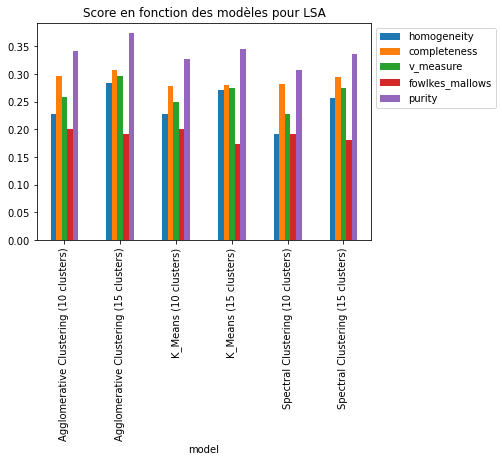

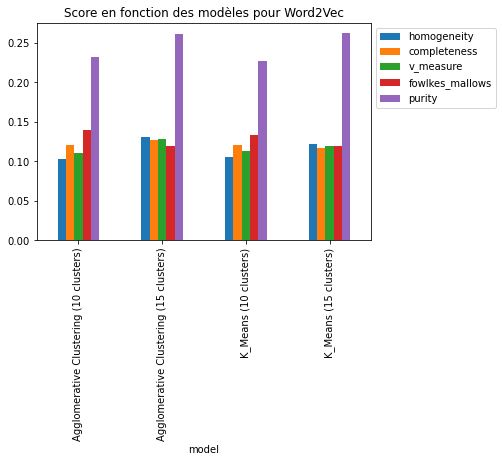

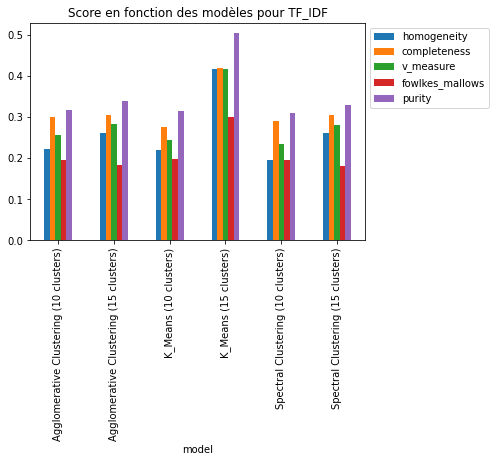

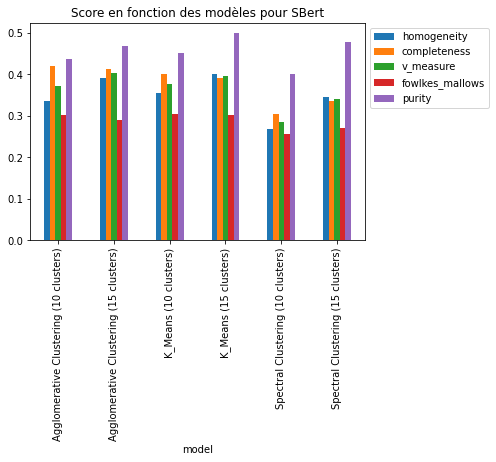

In [100]:
for repr in set(df.representation):
    df_per_reprensentation(repr,df)

In [101]:
def df_per_model(model,df):
    df_repre = df[df.model==model]
    ax = df_repre.plot.bar(x='representation',title = model)
    ax.legend(bbox_to_anchor=(1.0, 1.0))

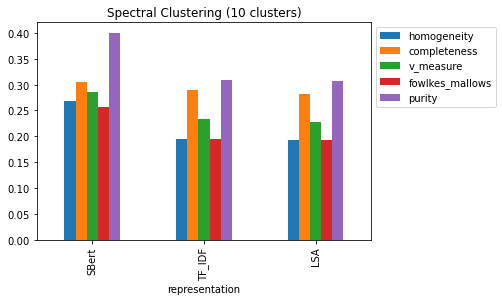

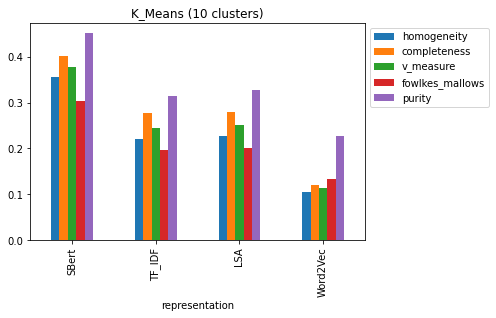

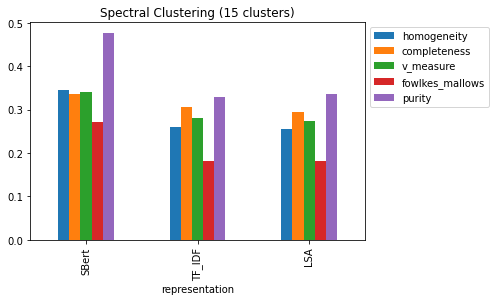

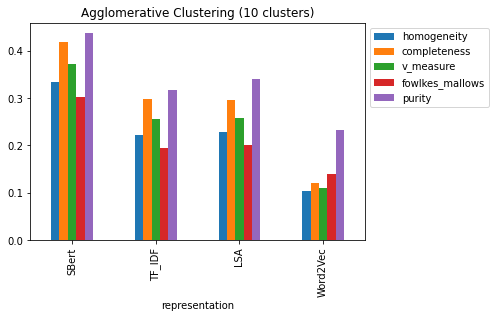

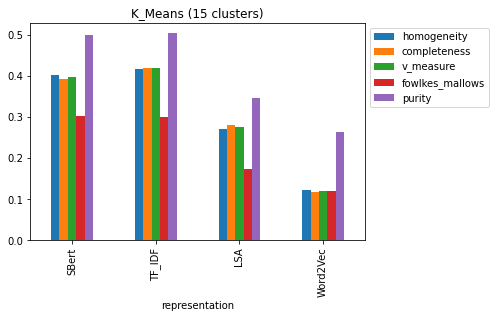

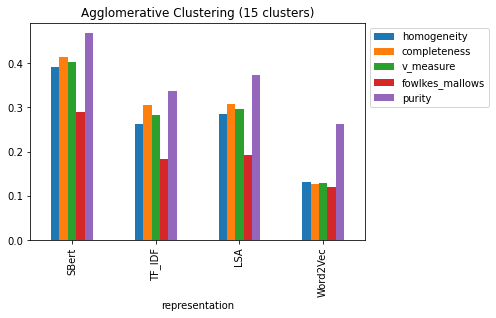

In [102]:
for model in set(df.model):
    df_per_model(model,df)